# Percepción Computacional
## Laboratorio Grupal: Corrección de anomalías
##### Albert Fernandez Lozano
##### Ander Lanas Alocén
##### Emili Bota Batlle
##### María de la Cruz Ramírez Trujillo
##### Olatz Urrutia Etxebarria
v. 27.12.2020 - 20:00:00

### Descripción del problema

En este laboratorio tenemos que escoger dos imágenes y corregir sus anomalías. Las imagenes que hemos escogido tenían contraste alto de colores y luminosidad. Hemos usado el autocontraste para suavizar los colores que resaltaban mucho, y avivar los colores que estaban muy bajos. Y para regular la luminosidad hemos ecualizado la imagen, balanceando los colores.

In [ ]:
#imports
from skimage import data,io,exposure
from skimage.color import rgb2hsv, hsv2rgb
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#Definición de funciones generales
def isGray(img):
    """Decide si una imagen es gris o multicolor (RGB)
    Parameters:
    img (numpy.array): Imagen en formato array de numpy
    Returns:
    boolean:Returning value
    """
    return np.isscalar(img[0][0])

def viewImg(img):
    """Permite visualizar una imagen
    Parameters:
    img (numpy.array): Imagen en formato array de numpy   
    """
    is_gray = isGray(img)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
    ax1.imshow(img,cmap=(plt.cm.gray if is_gray else None))
    ax1.set_xticks([]), ax1.set_yticks([])
    if (is_gray):
        ax2.hist(img.ravel(), bins=256)
    else:
        ax2.hist(img[:,:,0].ravel(), bins=256, color='red', alpha=0.5)
        ax2.hist(img[:,:,1].ravel(), bins=256, color='green', alpha=0.5)
        ax2.hist(img[:,:,2].ravel(), bins=256, color='blue', alpha=0.5)
    plt.show()

In [ ]:
#Importamos la/s imagen/es que queremos utilizar
images = [[]]
print('Start loading images...')
for i in np.arange(1,11):
    images.append(io.imread(f'original_images/img{i}.bmp'))
print('All images loaded!')

Start loading images...
All images loaded!


### Auto-contraste de imagen


En primer lugar, calculamos el percentil que consideramos correcto y seguidamente lo aplicamos en el histograma para adaptarlo.
Uso del percentil: recortamos el rango del histograma de la imagen al 1%. Escalamos usando el máximo relativo al 1% (`getPercentil(img,99)`) y el mínimo relativo al 1% (`getPercentil(img,1)`). De esta manera hacemos desaparecer los posibles Outliers del histograma de la imagen y obtenemos así los claros más acentuados y oscuros más profundizados. 
Este algoritmo ayuda a solventar problemas relacionados con la intensidad de píxeles en la imagen. Es decir, hablamos de poca intensidad cuando nos parece que zonas de la imagen son poco apreciables debido al contraste con píxeles cercanos. Entonces, a través del autocontraste, lo que se consigue es resaltar esos mínimos (o bajar los máximos), para poder apreciar más características de la imagen. 

In [ ]:
def getPercentil(img,val,color=0):
    """Obtiene la intensidad de píxel del histograma el cual es mayor que el val% de los píxeles de la imagen
    Parameters:
    img (numpy.array): Imagen en formato array de numpy
    val (int): Percentil a buscar (% de valores dentro)
    color (int): Para imagenes de color, [0,1,2]->[R,G,B]
    Returns:
    int: Valor de píxel dentro del percentil con val elejido
    """
    return np.percentile(img if isGray(img) else img[:,:,color],val)

def autoContrast(img):
    """Aplica el autocontraste a una imagen
    Parameters:
    img (numpy.array): Imagen en formato array de numpy
    Returns:
    numpy.array: Imagen con el contraste aplicado
    """
    img_ac = np.copy(img)
    #Obtenemos los rangos para los loops
    r_height = np.arange(len(img_ac))
    r_width = np.arange(len(img_ac[0]))
    
    if (isGray(img)): #Si es gris
        #Con la función anterior, obtenemos los percentiles
        min_pctl = getPercentil(img,1)
        max_pctl = getPercentil(img,99)
        y = 255 / (max_pctl - min_pctl)
        z = min_pctl*y
        #Sólo tenemos que aplicarlo en un histograma
        for i in r_height:
            for j in r_width:
                img_ac[i][j]= min(255,max(y*img[i][j]-z,0))
   
    else: #Si es RGB
        #Aplicamos el auto-contraste a los tres histogramas
        
        for k in range(3):
            #recalculamos el percentil en cada uno
            min_pctl = getPercentil(img,1,k)
            max_pctl = getPercentil(img,99,k)
            y = 255 / (max_pctl - min_pctl)
            z = min_pctl*y
            for i in r_height:
                for j in r_width:
                    img_ac[i][j][k]= min(255,max(y*img[i][j][k]-z,0))

    return img_ac

### Ecualización de imagen

Para ecualizar la imagen, en primer lugar utilizamos la función `normalizeHistogram`. Este es el corazón del algoritmo; obtiene un histograma y lo normaliza, dándonos un array donde los indices són los valores actuales de los píxeles y el valor es el valor por el que se tiene que cambiar para que la imagen se ecualize. La función `ecualize` aplica este array en la imagen, ecualizándola.

El problema que nos encontramos es que, al ecualizar imagenes de color, el balance de los colores podia quedar afectado, haciendo que la imagen quedara extraña. Encontramos [la solución](https://ieeexplore.ieee.org/document/1257395?arnumber=1257395); podemos pasar la imagen de RGB a HSV y normalizar la luminosidad de esta, para que la integridad de color se mantenga; esto lo conseguimos con la función `equalizeLuminosity`, y como podremos ver en la ejecución los resultados obtenidos parecen más prometedores que con la anterior versión.




In [ ]:
def normalizeHistogram(array):
    """Normaliza el histograma introducido
    Parameters:
    array (numpy.array): Conjunto de valores de un canal de la imagen
    Returns:
    numpy.array: Array de transformaciones a hacer por cada valor del array entrado
    """
    freqs = np.bincount(array.flatten())
    for (i,pixel) in enumerate(reversed(freqs)):
        if pixel != 0:
            max_pixel_value = i
            break
    max_pixel_value = (len(freqs) - 1) - max_pixel_value
    cumm_freqs = np.cumsum(freqs)
    norm_freqs = np.round(( cumm_freqs / cumm_freqs[-1] ) * max_pixel_value)
    return norm_freqs

def equalize(img):
    """Ecualiza la imagen
    Parameters:
    img (numpy.array): Imagen en formato array de numpy
    Returns:
    numpy.array: Imagen ecualizada
    """
    img_eq = np.copy(img)
    #Obtenemos los rangos para los loops
    r_height = np.arange(len(img_eq))
    r_width = np.arange(len(img_eq[0]))
    if (isGray(img)): #Es gris
        norm = normalizeHistogram(img_eq)
        #print('normalized')
        for j in r_height:
            for k in r_width:
                img_eq[j][k] = norm[img_eq[j][k]]

    else: #Es RGB
        for color in range(3):
            norm = normalizeHistogram(img_eq[:,:,color])
            #print('normalized color '+str(color))
            for l in r_height:
                for m in r_width:
                    img_eq[l][m][color] = norm[img_eq[l][m][color]]
    return img_eq

def equalizeLuminosity(img):
    """Ecualiza la luminosidad de la imagen
    Parameters:
    img (numpy.array): Imagen en formato array de numpy
    Returns:
    numpy.array: Imagen ecualizada
    """
    img_hsv = rgb2hsv(img)
    img_llum = img_hsv[:,:,2]
    img_rescaled = np.round(img_llum*10000).astype(int)
    #print(img_rescaled)
    img_hsv_output = equalize(img_rescaled) / 10000.0
    img_hsv[:,:,2] = img_hsv_output
    img_rgb = hsv2rgb(img_hsv)
    return img_rgb

### Ejecución

Finalmente mostramos el funcionamiento interactivo de nuestra implementación; Modifique el valor de `img_index` para utilizar una de las fotos seleccionadas y ver el cambio en esta

In [ ]:
#Índice de la imagen a tratar
def showResults(img_index):
  img = None
  if (img_index >= len(images) or img_index < 1):
    print(f'Indice de imagen incorrecto: tiene que estar entre 1 y {len(images)-1}')
    return None
  else:
    img = images[img_index]
  print('Imagen básica seleccionada:');
  viewImg(img)

  print('Imagen con auto-contraste:')
  img_con_contraste = autoContrast(img)
  viewImg(img_con_contraste)

  print('Imagen ecualizada (1a Versión):')
  img_equaliz1 = equalize(img)
  viewImg(img_equaliz1)

  print('Imagen ecualizada (2a Versión):')
  img_equaliz2 = equalizeLuminosity(img)
  viewImg(img_equaliz2)

Imagen básica seleccionada:


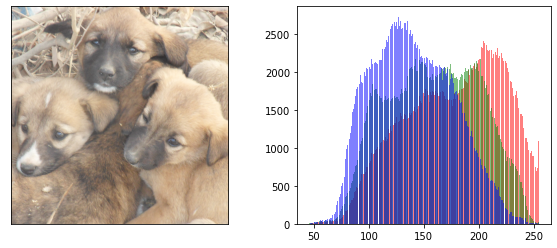

Imagen con auto-contraste:


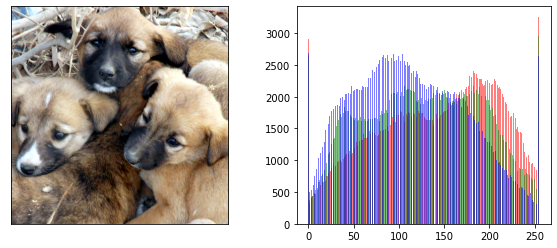

Imagen ecualizada (1a Versión):


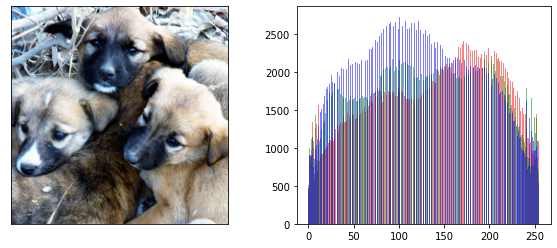

Imagen ecualizada (2a Versión):


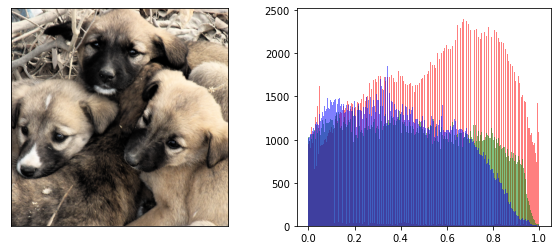

In [ ]:
showResults(2)

Imagen básica seleccionada:


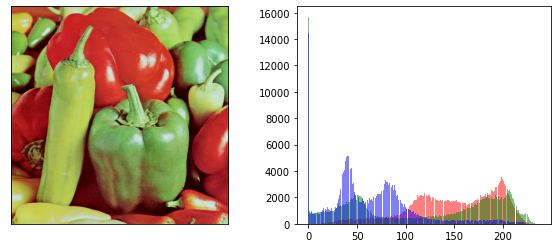

Imagen con auto-contraste:


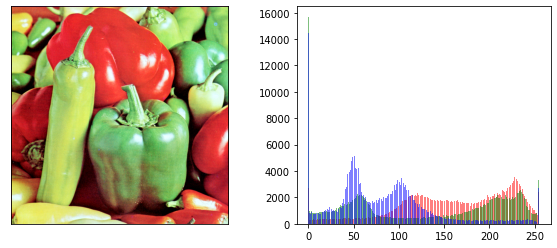

Imagen ecualizada (1a Versión):


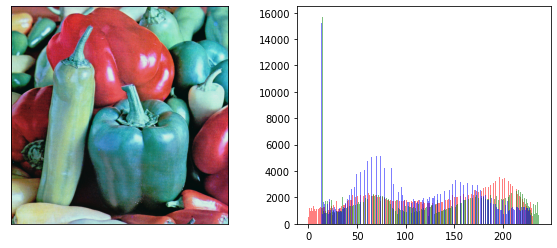

Imagen ecualizada (2a Versión):


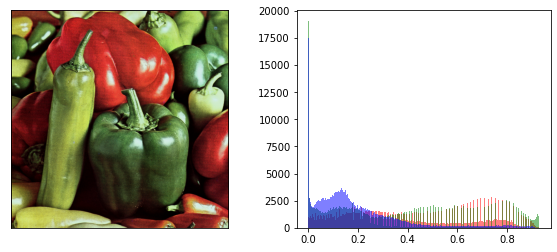

In [ ]:
showResults(9)